In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [2]:
liar_data = pd.read_csv('feverous.csv', names=["ID", "label", "claim", "evidence", "annotator_operations", "expected_challenge", "challenge"])

In [3]:
liar_data = liar_data.drop(0)

In [4]:
liar_data['label'] = liar_data['label'].replace({
    'NOT ENOUGH INFO': 0,
    'REFUTES': 0,
    'SUPPORTS': 1,
})

In [5]:
# Select only the relevant columns for our task
liar_data = liar_data[['claim', 'label']]

In [6]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(liar_data, test_size=0.2, random_state=42)

In [7]:
# Tokenize the statements using Keras' Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['claim'])

In [8]:
# Convert the tokenized sequences to padded sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['claim']), maxlen=100)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['claim']), maxlen=100)

In [9]:
# Build the RNN model
model = Sequential()
model.add(Embedding(5000, 64))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, train_data['label'], batch_size=64, epochs=50, validation_split=0.1, callbacks=[early_stop])

Epoch 1/50
802/802 [==============================] - 185s 211ms/step - loss: 0.6587 - accuracy: 0.6177 - val_loss: 0.6431 - val_accuracy: 0.6357
Epoch 2/50
802/802 [==============================] - 141s 176ms/step - loss: 0.6253 - accuracy: 0.6537 - val_loss: 0.6501 - val_accuracy: 0.6390
Epoch 3/50
802/802 [==============================] - 139s 173ms/step - loss: 0.5957 - accuracy: 0.6780 - val_loss: 0.6533 - val_accuracy: 0.6292
Epoch 4/50
802/802 [==============================] - 148s 185ms/step - loss: 0.5639 - accuracy: 0.7008 - val_loss: 0.6697 - val_accuracy: 0.6273


In [12]:
# Evaluate the model on the test set
score, acc = model.evaluate(X_test, test_data['label'], batch_size=64)
print('Test score:', score)
print('Test accuracy:', acc)

223/223 [==============================] - 10s 43ms/step - loss: 0.6834 - accuracy: 0.6221
Test score: 0.6834183931350708
Test accuracy: 0.6220632791519165


In [13]:
# Make predictions on the test set and calculate evaluation metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

446/446 [==============================] - 9s 19ms/step


In [14]:
print(test_data['label'].shape)
print(y_pred.shape)

(14259,)
(14259, 1)


In [15]:
print(classification_report(test_data['label'], y_pred_labels))

              precision    recall  f1-score   support

           0       0.42      1.00      0.59      5959
           1       0.00      0.00      0.00      8300

    accuracy                           0.42     14259
   macro avg       0.21      0.50      0.29     14259
weighted avg       0.17      0.42      0.25     14259



C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shruti29\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[5959    0]
 [8300    0]]


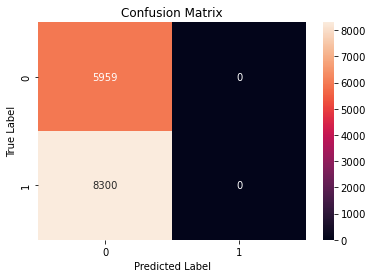

In [16]:
cm = confusion_matrix(test_data['label'], y_pred_labels)
print(f'Confusion Matrix:\n{cm}')
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

AUC: 0.500


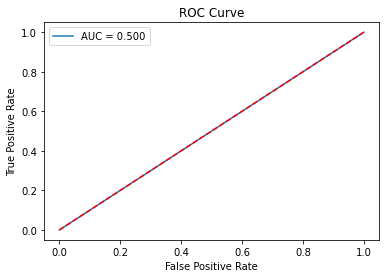

In [17]:
fpr, tpr, thresholds = roc_curve(test_data['label'], y_pred_labels)
auc = roc_auc_score(test_data['label'], y_pred_labels)
print(f'AUC: {auc:.3f}')
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()